The purpose of this notebook is to show that read depth is not confounded with aspiration status, as justification for why we did not rarefy anywhere.

It's also got some scratch work to plot a rarefaction curve.

In [27]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [33]:
fname = '../../data/clean/rosen.otu_table.counts.clean'
fmeta = '../../data/clean/rosen.metadata.clean'

df = pd.read_csv(fname, sep='\t', index_col=0)
meta = pd.read_csv(fmeta, sep='\t', index_col=0)
'total_reads' in meta.columns

True

In [34]:
sites = ['bal', 'throat_swab', 'gastric_fluid']
meta = meta.query('site == @sites')

In [35]:
meta['log_reads'] = np.log10(meta['total_reads'])
cols = ['log_reads', 'total_reads', 'site', 'mbs_consolidated']
total_reads = meta[cols].fillna('nan')
total_reads.groupby(['site', 'mbs_consolidated']).describe()

log_reads                                \
                                         count      mean       std       min   
site          mbs_consolidated                                                 
bal           Aspiration/Penetration      35.0  4.148887  0.482442  3.145196   
              Normal                      44.0  3.937242  0.564797  3.008600   
              nan                         52.0  3.951672  0.589432  2.469822   
gastric_fluid Aspiration/Penetration      44.0  4.118863  0.486430  3.089905   
              Normal                      56.0  4.318729  0.649248  2.127105   
              nan                         81.0  4.275472  0.641317  2.918030   
throat_swab   Aspiration/Penetration      39.0  4.345798  0.429583  3.159868   
              Normal                      47.0  4.473038  0.387555  3.037426   
              nan                        163.0  4.480391  0.545388  2.227887   

                                                                              \
                                           25%       50%       75%       max   
site          mbs_consolidated                                                 
bal           Aspiration/Penetration  3.824202  4.188563  4.427215  5.089736   
              Normal                  3.450962  3.909803  4.446146  4.793700   
              nan                     3.414395  3.914036  4.461476  5.191311   
gastric_fluid Aspiration/Penetration  3.738499  4.111236  4.526774  5.288788   
              Normal                  3.981389  4.372266  4.822653  5.808022   
              nan                     3.769673  4.370661  4.804330  5.434537   
throat_swab   Aspiration/Penetration  4.320413  4.426283  4.614716  4.894144   
              Normal                  4.438460  4.551609  4.698708  5.053317   
              nan                     4.400243  4.616623  4.797675  5.413580   

                                     total_reads                              \
                                           count          mean           std   
site          mbs_consolidated                                                 
bal           Aspiration/Penetration        35.0  25059.257143  30264.104975   
              Normal                        44.0  17344.886364  17899.105218   
              nan                           52.0  20299.769231  28813.836399   
gastric_fluid Aspiration/Penetration        44.0  24202.363636  33282.238401   
              Normal                        56.0  51192.214286  92285.237369   
              nan                           81.0  44790.395062  58294.547728   
throat_swab   Aspiration/Penetration        39.0  30858.282051  20471.514749   
              Normal                        47.0  38093.872340  21392.023022   
              nan                          163.0  48227.613497  39660.999948   

                                                                           \
                                         min       25%      50%       75%   
site          mbs_consolidated                                              
bal           Aspiration/Penetration  1397.0   6673.50  15437.0  26745.00   
              Normal                  1020.0   2825.25   8173.0  27966.75   
              nan                      295.0   2597.00   8213.0  28938.50   
gastric_fluid Aspiration/Penetration  1230.0   5477.75  12938.0  33645.75   
              Normal                   134.0   9599.25  23566.5  66507.50   
              nan                      828.0   5884.00  23478.0  63728.00   
throat_swab   Aspiration/Penetration  1445.0  20918.50  26686.0  41183.00   
              Normal                  1090.0  27448.50  35613.0  49997.50   
              nan                      169.0  25133.50  41364.0  62759.00   

                                                
                                           max  
site          mbs_consolidated                  
bal           Aspiration/Penetration  122952.0  
              Normal             

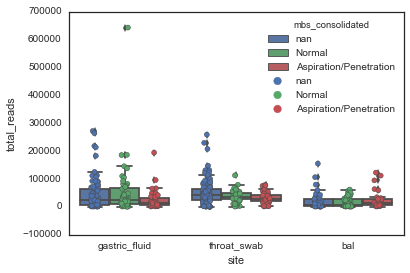

In [206]:
sns.boxplot(data=total_reads, x='site', y='total_reads', hue='mbs_consolidated')
sns.stripplot(data=total_reads, x='site', y='total_reads', hue='mbs_consolidated',
            jitter=True, split=True, linewidth=0.5)

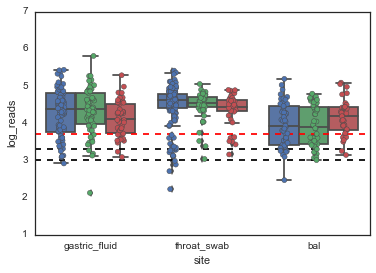

In [214]:
sns.boxplot(data=total_reads, x='site', y='log_reads', hue='mbs_consolidated')
sns.stripplot(data=total_reads, x='site', y='log_reads', hue='mbs_consolidated',
            jitter=True, split=True, linewidth=0.5)
plt.plot(plt.xlim(), [np.log10(1000), np.log10(1000)], 'k--')
plt.plot(plt.xlim(), [np.log10(2000), np.log10(2000)], 'k--')
plt.plot(plt.xlim(), [np.log10(5000), np.log10(5000)], 'r--')
plt.legend([])

In [40]:
np.log10(2000)

3.3010299956639813

# Rarefaction curve

Pseudo code:

```
for n in [range of N reads to downsample]:
    for i in range(20):
        subsample each sample
        calculate a couple of different alpha diversities (number of OTUs, shannon)
        store: sample, n, alpha_type, alpha_val, i

# Plotting
groupby(sample).mean()
merge with site metadata
for each value of alpha:
    plot(x=n, y=alpha, color=site)
```

In [161]:
from skbio.stats import subsample_counts
from skbio.diversity.alpha import chao1, shannon, simpson_e, observed_otus

In [162]:
fotu = '../../data/clean/rosen.otu_table.counts.clean'
fmeta = '../../data/clean/rosen.metadata.clean'

df = pd.read_csv(fotu, sep='\t', index_col=0)
meta = pd.read_csv(fmeta, sep='\t', index_col=0)

# Transpose dataframe so samples are in columns
df = df.T

In [163]:
def my_subsample(col, n):
    """
    Subsample n reads from col. If col does not
    have at least n reads, do not return that column.
    
    This wrapper is needed bc skbio's subsample_counts
    throws an error if there aren't enough reads.
    """
    if sum(col) >= n:
        return subsample_counts(col, n)
    else:
        return [np.nan]*len(col.index)

In [199]:
n_reads = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 1000, 1500, 2000, 5000, 7000]
alpha_metrics = {'chao1': chao1, 'shannon': shannon, 'simpson_e': simpson_e, 'observed': observed_otus}

# This list will contain all the final results
rare_lst = []
for n in n_reads:
    print(n)
    for i in range(10):
        print(i),
        subdf = df.apply(lambda col: my_subsample(col, n))
        subdf = subdf.dropna(how='all', axis=1)

        # Calculate new alpha diversity
        for name, fun in alpha_metrics.iteritems():
            a = pd.DataFrame(subdf.apply(fun), columns=['alpha_val']).reset_index()
            a = a.rename(columns={'index': 'sample'})
            a['alpha_type'] = name
            a['n'] = n
            a['iteration'] = i
            rare_lst.append(a)
    print('')


50
0 1 2 3 4 5 6 7 8 9 
100
0 1 2 3 4 5 6 7 8 9 
150
0 1 2 3 4 5 6 7 8 9 
200
0 1 2 3 4 5 6 7 8 9 
250
0 1 2 3 4 5 6 7 8 9 
300
0 1 2 3 4 5 6 7 8 9 
350
0 1 2 3 4 5 6 7 8 9 
400
0 1 2 3 4 5 6 7 8 9 
450
0 1 2 3 4 5 6 7 8 9 
500
0 1 2 3 4 5 6 7 8 9 
1000
0 1 2 3 4 5 6 7 8 9 
1500
0 1 2 3 4 5 6 7 8 9 
2000
0 1 2 3 4 5 6 7 8 9 
5000
0 1 2 3 4 5 6 7 8 9 
7000
0 1 2 3 4 5 6 7 8 9 


In [200]:
raredf = pd.concat(rare_lst, ignore_index=True)
# Merge with site metadata
raredf = pd.merge(raredf, meta[['batch', 'site']], left_on='sample', right_index=True)
means = raredf.groupby(['sample', 'site', 'alpha_type', 'n']).mean().reset_index()

In [201]:
sites = ['bal', 'throat_swab', 'gastric_fluid']

#g = sns.FacetGrid(data=means.query('site == @sites'), col='alpha_type', row='site', sharey=False)
## Gr this isn't working bc all the lines are connected
#g.map(sns.plt.plot, 'n', 'alpha_val', linewidth=0.1)

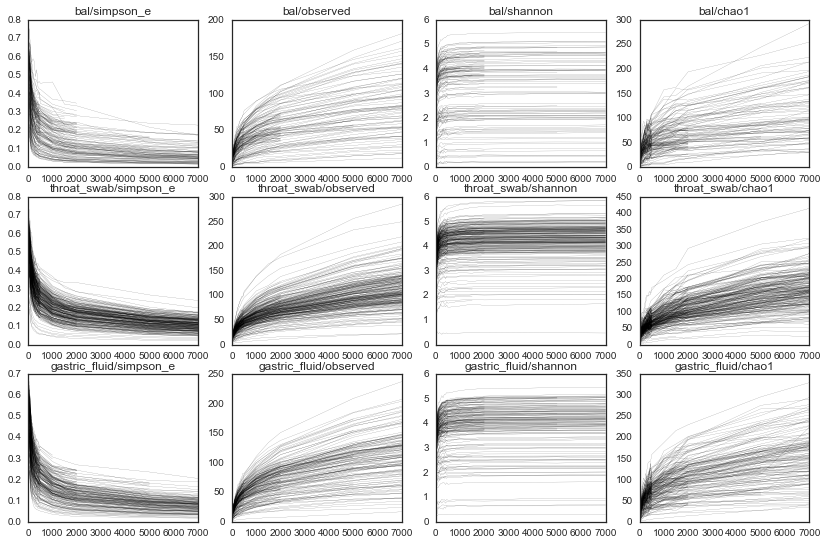

In [202]:
# Fine I'll just do it manually...
sns.set_style('white')
fig, ax = plt.subplots(3, 4, figsize=(14, 9))
ax = ax.flatten()

i = 0
for site in sites:
    for alpha_type in raredf['alpha_type'].unique():
        subdf = means.query('site == @site').query('alpha_type == @alpha_type')
        for _, sampledf in subdf.groupby('sample'):
            ax[i].plot(sampledf['n'], sampledf['alpha_val'], 'k', linewidth=0.1)
        ax[i].set_title(site + '/' + alpha_type)
        i += 1
        

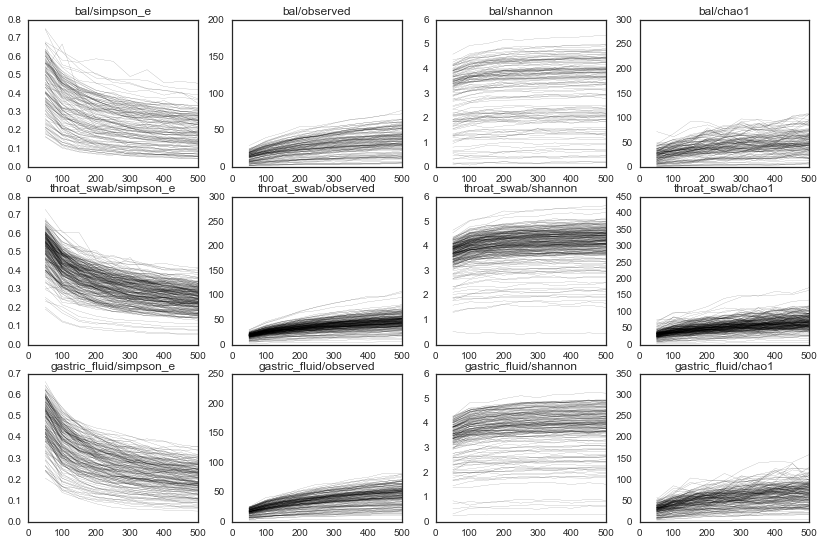

In [203]:
# Fine I'll just do it manually...
sns.set_style('white')
fig, ax = plt.subplots(3, 4, figsize=(14, 9))
ax = ax.flatten()

i = 0
for site in sites:
    for alpha_type in raredf['alpha_type'].unique():
        subdf = means.query('site == @site').query('alpha_type == @alpha_type')
        for _, sampledf in subdf.groupby('sample'):
            ax[i].plot(sampledf['n'], sampledf['alpha_val'], 'k', linewidth=0.1)
        ax[i].set_title(site + '/' + alpha_type)
        
        # Zoom in
        ax[i].set_xlim([0, 500])
        
        i += 1
        